# Air pump failure analysis

Following statements are deduced from given task `README.md`.

### Important observations
- sharp start and end of pressure (normally stable)
- slow start, end or pressure drops could mean pump failure
- typical air pump failure due to pressure drop in the first half of the cycle
- pressure is saved as a time series (ordered, same intervals)

### Data structure 
- MachineId, MeasurementId are Id's of machine and cycle
- Pressure (kPa)
- PumpFailed, SlowStart, SlowEnd (bool features)

### Task
- develop predictive model from `PumpFailed` and measure performance
- explain model

# Basic observations

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snss

INDEXES = ['MachineId', 'MeasurementId']
TARGET = ['PumpFailed']

RANDOM_STATE = 42

In [2]:
def print_unique_values(df: pd.DataFrame):
    """ Print unique values for each feature in given dataframe """
    
    print('Unique values:')
    for feature in df.columns:
        print(f"{feature:15} : {len(df[feature].unique())}")

## Labels dataframe

In [3]:
df_labels = pd.read_csv('data/labels.csv')

display(df_labels.head())
display(df_labels.info())

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27385 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      27385 non-null  object
 1   MeasurementId  27385 non-null  int64 
 2   PumpFailed     26900 non-null  object
 3   SlowStart      19300 non-null  object
 4   SlowEnd        19300 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


None

MachineId           0
MeasurementId       0
PumpFailed        485
SlowStart        8085
SlowEnd          8085
dtype: int64

[]

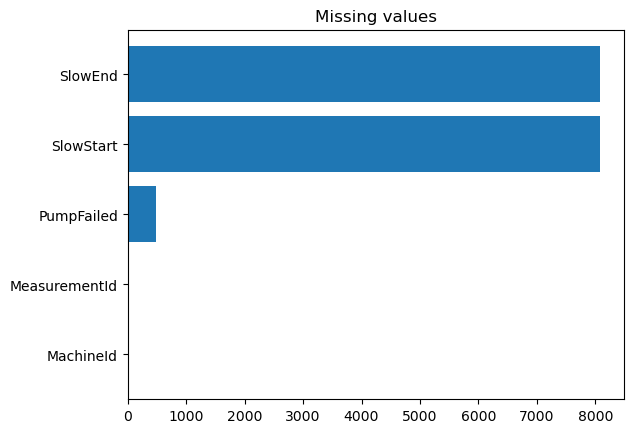

In [4]:
display(df_labels.isna().sum())

plt.barh(df_labels.columns, df_labels.isna().sum())
plt.title('Missing values')
plt.plot()

In [5]:
print_unique_values(df_labels)

print()
print('Biggest MeasurementId: ', df_labels['MeasurementId'].max())

Unique values:
MachineId       : 556
MeasurementId   : 8836
PumpFailed      : 3
SlowStart       : 3
SlowEnd         : 3

Biggest MeasurementId:  8834


In [6]:
# pump bool feature combinations (all: 8)

df_labels.loc[:, ['PumpFailed', 'SlowStart', 'SlowEnd']].dropna().drop_duplicates()

# data does not contain any pumps with states:
# (true, true, true) -> pump failed with both slow start and end
# (true, true, false) -> pump failed only with slow start

,PumpFailed,SlowStart,SlowEnd
0,False,False,False
3,True,False,False
8,False,True,False
21,False,False,True
2564,True,False,True
7825,False,True,True


Observations:
- 27385 entries, 5 columns, most of them are object as type
- nan values in rows with measurementid = -1
- 556 unique machines and 8836 unique measurement cycles
- bool features has nan, false, true because of 3 unique values
- biggest measurementid is 8834 which should fit into int16 type for memory saving
- 6 binary feature combinations -> I can plot example data for each of them

### Target feature

PumpFailed
False    23958
True      2942
Name: count, dtype: int64

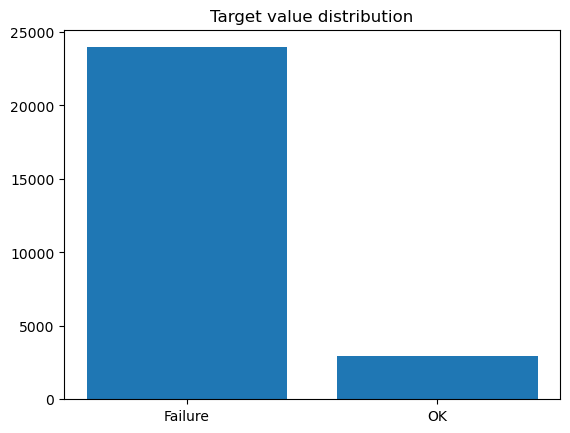

In [7]:
# check target value counts
target_counts = df_labels['PumpFailed'].value_counts()
display(target_counts)

plt.bar(x=['Failure', 'OK'], height=target_counts)
plt.title('Target value distribution')
plt.show()

After looking at basic `df_labels` info, I will:
- drop rows with missing values, because of large amount of data.
    - other option is to look more closely at the connection with pressure value (it could create third category for SlowStart, SlowEnd)
    - but for now and because of limited time, I'll drop all rows with NaN values
- change types to save memory

Another problem, which is quite obvious from target value distribution, is the imbalanced dataset. This could be fixed using appropriate metric, modify prediction model to give larger weight to less frequent target, augmenting the dataset.
- in this case I'll use f1-score instead of most commonly used accuracy for model preformance evaluation
- then I could try to apply some version of data bootsrapping

In [8]:
# drop NaN and change types
df_labels = df_labels.dropna().astype({
    'MachineId' : 'category',
    'MeasurementId' : 'int16',
    'PumpFailed' : 'bool',
    'SlowStart' : 'bool',
    'SlowEnd' : 'bool'
})

display(df_labels.info())

# ratio after drop
print((df_labels['PumpFailed'].value_counts()[False] / df_labels['PumpFailed'].value_counts().sum()).round(2))
print((df_labels['PumpFailed'].value_counts()[True] / df_labels['PumpFailed'].value_counts().sum()).round(2))

<class 'pandas.core.frame.DataFrame'>
Index: 19300 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MachineId      19300 non-null  category
 1   MeasurementId  19300 non-null  int16   
 2   PumpFailed     19300 non-null  bool    
 3   SlowStart      19300 non-null  bool    
 4   SlowEnd        19300 non-null  bool    
dtypes: bool(3), category(1), int16(1)
memory usage: 293.7 KB


None

0.89
0.11


I can also see, that the target value is distributed in 9:1 ratio.

## Data dataframe

In [9]:
df_data = pd.read_parquet('data/data.parquet', engine='fastparquet')

In [10]:
display(df_data.head())
display(df_data.info())

,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB


None

In [11]:
display(df_data.isna().sum())

MachineId        0
MeasurementId    0
Pressure         0
dtype: int64

In [12]:
print_unique_values(df_data)

print()
print('Largest pressure (kPa): ', df_data['Pressure'].max())

Unique values:
MachineId       : 556
MeasurementId   : 8836
Pressure        : 386064

Largest pressure (kPa):  6.774464119291705


Observations:
- there are no missing values
- this dataset consists of only IDs and pressure values ordered by time with fixed time distance measurements
    - that means, I need to work with pressure values as time series

In [13]:
# retype
df_data = df_data.astype({
    'MachineId' : 'category',
    'MeasurementId' : 'int16',
    'Pressure' : 'float32',
})

display(df_data.dtypes)

MachineId        category
MeasurementId       int16
Pressure          float32
dtype: object

In [14]:
# merge datasets using MachineId and MeasurementId
df_merged = pd.merge(df_data, df_labels, on=INDEXES)
df_merged.head()

,MachineId,MeasurementId,Pressure,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,0.0,False,False,False
1,0_0_0,0,0.0,False,False,False
2,0_0_0,0,0.0,False,False,False
3,0_0_0,0,0.0,False,False,False
4,0_0_0,0,0.0,False,False,False


## Merged dataframe pivoting

The dataframe is currently in merged state with ordered ressure measurements.
What I'll try to do now, is to pivot that dataframe, so that measured pressure values are shown ordered by time, but each column will represent unique measurement.

With that format I could manipulate easily with pressure measurements as time series.

In [15]:
# select both IDs and pressure features and set "categorical" dataframe index (set_index does not change order of rows)
df_measurements = df_merged.loc[:, ['MachineId', 'MeasurementId', 'Pressure']].set_index(INDEXES)
df_measurements.head()

Pressure
MachineId MeasurementId          
0_0_0     0                   0.0
          0                   0.0
          0                   0.0
          0                   0.0
          0                   0.0

In [16]:
# create new column time where value is incremented by one when pressure belongs to same indexes
# example: MachineId = 0_0_0 and MeasurementId = 0 will have increasing time series until it finds new Machine or Measurement ID 
df_measurements['Time'] = df_measurements.groupby(level=INDEXES, observed=False).cumcount()
df_measurements.head()

Pressure  Time
MachineId MeasurementId                
0_0_0     0                   0.0     0
          0                   0.0     1
          0                   0.0     2
          0                   0.0     3
          0                   0.0     4

In [17]:
# now it is just pivoting the table and replacing all shorter measurement sequences NaN values with zero 
df_measurements = df_measurements.pivot_table(index=INDEXES, columns='Time', values='Pressure', aggfunc='first', fill_value=0)
display(df_measurements.head())

assert df_measurements.shape[0] == df_labels.shape[0] # row count sanity check

Time                     0     1     2     3     4     5     6     7     8     \
MachineId MeasurementId                                                         
0_0_0     0               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          215             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          237             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          353             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          411             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

Time                     9     ...  1189  1190  1191  1192  1193  1194  1195  \
MachineId MeasurementId        ...                                             
0_0_0     0               0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          215             0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          237             0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          353             0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          411             0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

Time                     1196  1197  1198  
MachineId MeasurementId                    
0_0_0     0               0.0   0.0   0.0  
          215             0.0   0.0   0.0  
          237             0.0   0.0   0.0  
          353             0.0   0.0   0.0  
          411             0.0   0.0   0.0  

[5 rows x 1199 columns]

In [18]:
# now I'll just merge it with dataframe containing bool features and target value
df_all = pd.merge(df_labels.set_index(INDEXES), df_measurements, left_index=True, right_index=True).reset_index()

# Exploratory data analysis

In this section, I want to primarily plot example data of pressure time series and then check binary feature importance to predict target value.

In [19]:
# test correlation between target and binary features
df_labels.loc[:, ['PumpFailed', 'SlowStart', 'SlowEnd']].corr().round(2)

,PumpFailed,SlowStart,SlowEnd
PumpFailed,1.00,-0.09,-0.18
SlowStart,-0.09,1.00,-0.12
SlowEnd,-0.18,-0.12,1.00


- from correlation table I can't say that data are correlated or not
    - note: 
    - correlation is not the best test for binary features (there are better tests)
    - but it could still be good indicator

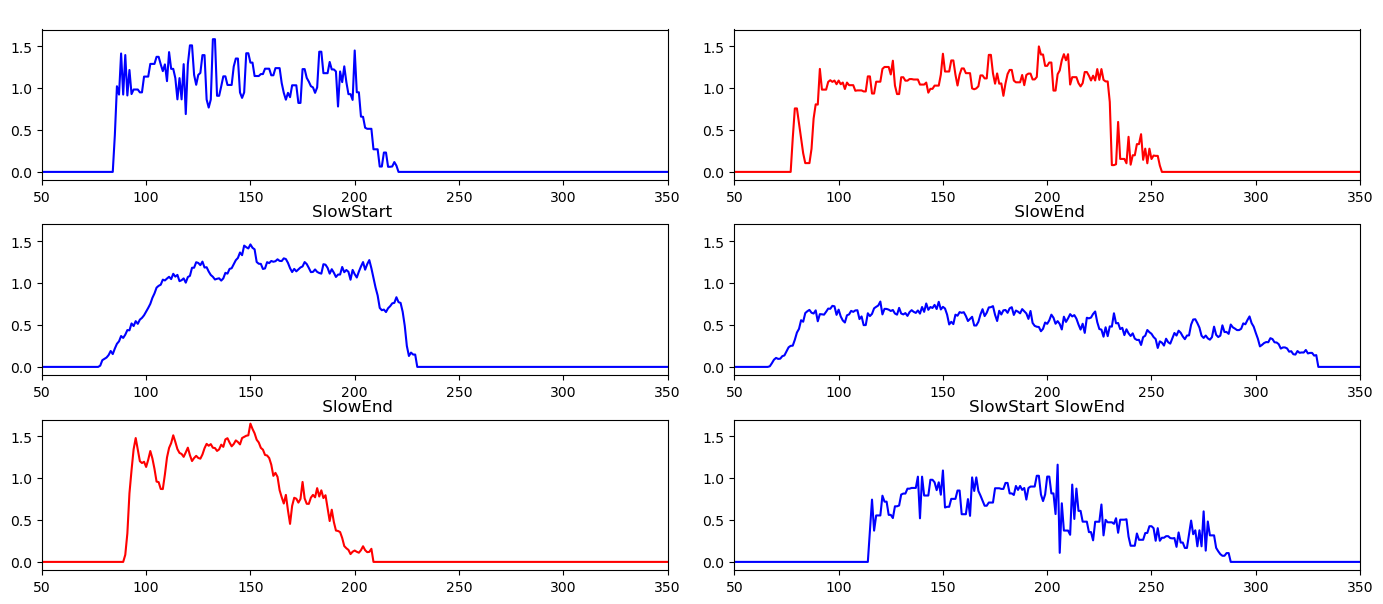

In [20]:
# beacause of only 6 bool feature combinations, I will plot example presure in time data for each of them 

# plot config
xlim, ylim = (50, 350), (-0.1, 1.7)
fig, axes = plt.subplots(3, 2, figsize = (14, 6))
fig.tight_layout()

# get possible combinations
combinations = df_all[['PumpFailed', 'SlowStart', 'SlowEnd']].drop_duplicates()

# loop for each bool feature combination
for i, [_ , [fail, start, end]] in enumerate(combinations.iterrows()):
    
    # get first pump matching feature combination
    first_pump_match = df_all[(df_all['PumpFailed'] == fail) & (df_all['SlowStart'] == start) & (df_all['SlowEnd'] == end)].iloc[0]
    
    # get machine and measurement id
    machine, measurement = first_pump_match['MachineId'], first_pump_match['MeasurementId']

    # get pressure series for given machine and cycle
    series_pressure = df_all[(df_all['MachineId'] == machine) & (df_all['MeasurementId'] == measurement)].iloc[0, 5:].reset_index(drop=True)

    # plot pressure in time for each combination
    ax = axes.ravel()[i]
    ax.plot(series_pressure, color='r' if fail else 'b')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(f"{'SlowStart' if start else ''} {'SlowEnd' if end else ''}")

plt.show()

The plot above shows example data for each present combination where `red` means failure and `blue` means ok air pump.
There are also bool features above each plot.

Understanding data based on all possible boolean combinations

- pump might fail due to fast drop at the beginning
- slow pressure decrease at the end could also mean pump failure
- low pressure could not necessarly mean pump failure (could be more about the pressure change speed in time) 

# Feature engineering

Due to the pressure being time series, it would be probably better to create features such as:
- how long was pump running for
- pressure mean, variance, max
- pressure changes in time like:
    - largest drop, largest spike
    - time series decomposition (trend, seasonality, residual) more about actuasl pressure prediction

- then it could help to standardize, normalize data after doing new feature extraction

In [21]:
# get only pressure dataframe
df_pressure = df_all.iloc[:, 5:]

In [22]:
# I'll create function which will return starting and ending index based on where pressure is not zero
# then I'll drop all unnecessary columns based on the smallest starting index and largest ending index
# this will produce same measured windows for each measured cycle but without too many zeroes

ZERO_SEQ = (-1, -1)

def get_nonzero_seq(df: pd.DataFrame):
    """ Get nonzero sequence (start, end) indexes from each row of given dataframe | (-1, -1) for full empty sequences """
    seq = []

    for _, row in df.iterrows():
        indexes = row[row > 0].index

        if len(indexes):
            seq.append((indexes[0], indexes[-1]))
        else:
            seq.append((-1, -1))

    return seq

seq = get_nonzero_seq(df_pressure)
filter_seq = list(filter(lambda x: x != ZERO_SEQ, seq))

seq_start, seq_end = min([x[0] for x in filter_seq]), max([x[1] for x in filter_seq])

print(f"Earliest pump activity (time): {seq_start}")
print(f"Latest pump activity (time):   {seq_end}")

# largest sequence start on 34 and ends on 1065 (not necessary the same measurement cycle)
# I'll add like 10 time ticks as a reserve to have at least some zero pressure data in the largest measurement cycles

Earliest pump activity (time): 34
Latest pump activity (time):   1065


In [23]:
# drop unnecessary zeroes and reindex columns from zero
reserve = 5 # reserve 5 zeroes at start and end of each sequence             

df_pressure = df_pressure.iloc[:, seq_start - reserve:seq_end + reserve]
df_pressure.columns = range(len(df_pressure.columns))
df_pressure.shape

(19300, 1041)

In [24]:
# now I am finally going to create some new features from cycle measurements

cycle_length = pd.Series([0 if idx == ZERO_SEQ else idx[1] - idx[0] for idx in seq])
mean = df_pressure.mean(axis=1)
var = df_pressure.var(axis=1)
max_pressure = df_pressure.max(axis=1)

print(f"Min/Max measurement cycle length: {cycle_length.min()}, {cycle_length.max()}")
print(f"Measurement cycle mean, var, std: {cycle_length.mean():.3f}, {cycle_length.var():.3f}, {cycle_length.std():3f}")

# those are the simple features
# min measurement cycle length is 0 which is not optimal, but with given time I'll skip it for now
# also mean of cycle length is ~205.6, so I could create new features based on longer cycle or to drop outliers based

Min/Max measurement cycle length: 0, 912
Measurement cycle mean, var, std: 204.947, 8732.103, 93.445725


In [25]:
# now for the pressure change features
# I could try to create largest pressure drop or spike in raw pressure value or in precentage

# now I'll create new features dataframe and then I'll concat it with the original needed features
new_features = pd.DataFrame({
    'Length' : cycle_length,
    'Mean' : mean,
    'Var' : var,
    'MaxPressure': max_pressure,
})

new_features.head()

,Length,Mean,Var,MaxPressure
0,135,0.132591,0.132998,1.584466
1,198,0.156927,0.111036,1.205104
2,176,0.161324,0.150037,1.497921
3,152,0.147105,0.136563,1.470103
4,151,0.140315,0.133975,1.462193


In [26]:
df_all_new_features = pd.concat((df_all[['PumpFailed', 'SlowStart', 'SlowEnd']], new_features), axis=1)

# Model construction
Because of the classification problem in supervised learning, I'll use `logistic regression`, `random forest` and `LDA`.
Then after running GridSearch with CV, I'll select best model from them and use it for final evaluation.

My main evaluation metric will be `f1-score` due to the dataset imbalance.

## Base data

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [28]:
# used model config
models = {
    'LogisticRegression' : {
        'model' : LogisticRegression(),
        'params' : {
            'model__random_state' : [RANDOM_STATE],
            'model__max_iter' : [500],
            'model__C' : np.linspace(1e-3, 1e3, 20)
        }
    },
    'RandomForestClassifier' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'model__random_state' : [RANDOM_STATE],
            'model__n_estimators' : [100],
            'model__max_depth' : [30, 50, 100],
        }
    },
    'LinearDiscriminantAnalysis' : {
        'model' : LinearDiscriminantAnalysis(),
        'params' : {
            
        }
    }
}

In [29]:
X, y = df_labels.drop(TARGET + INDEXES, axis=1), np.ravel(df_labels.loc[:, TARGET])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (14475, 2)
Test: (4825, 2)


In [30]:
best_models = {}

# run gridsearchCV to tune hyperparams
for model_name, conf in models.items():
    model, params = conf['model'], conf['params']

    pipe = Pipeline([('model', model)])

    grid_search = GridSearchCV(pipe, params, scoring=make_scorer(f1_score, greater_is_better=True), cv=5)
    grid_search.fit(X_train, y_train)   

    best_models[model_name] = {
        'model': grid_search.best_estimator_, 
        'params': grid_search.best_params_, 
        'score' : grid_search.best_score_
    }

In [31]:
# get best type of model after hyperparam tuning
model = max([(conf['score'], conf['model']) for conf in best_models.values()], key=lambda x: x[0])[1]
model.fit(X_train, y_train)

display(model.named_steps['model'])

print(f"f1 score (train):  {f1_score(y_train, model.predict(X_train)):.3f}")
print(f"f1 score (test):   {f1_score(y_test, model.predict(X_test)):.3f}")

print()

print(f"acc score (train): {accuracy_score(y_train, model.predict(X_train)):.3f}")
print(f"acc score (test):  {accuracy_score(y_test, model.predict(X_test)):.3f}")

LogisticRegression(C=0.001, max_iter=500, random_state=42)

f1 score (train):  0.000
f1 score (test):   0.000

acc score (train): 0.887
acc score (test):  0.892


Best performing model on base data (`SlowStart`, `SlowEnd`) is Log regression. But it is because all models scored 0 in f1-score.
Actual accuracy is not that bad, but it would be same as just always saying that `PumpFailure == False`, because of the 9:1 data ratio.

## New features
Now I'll test my new features with encoding and scaling.

In [32]:
X, y = df_all_new_features.drop(TARGET, axis=1), np.ravel(df_all_new_features.loc[:, TARGET])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (14475, 6)
Test: (4825, 6)


In [33]:
ct = ColumnTransformer([
    ('OneHot', OneHotEncoder(), ['SlowStart', 'SlowEnd']),
    ('MinMax', MinMaxScaler(), ['MaxPressure', 'Length']),
], remainder='passthrough')

In [34]:
best_models = {}

# run gridsearchCV to tune hyperparams
for model_name, conf in models.items():
    model, params = conf['model'], conf['params']

    pipe = Pipeline([
        ('prep', ct),
        ('model', model)
    ])

    grid_search = GridSearchCV(pipe, params, scoring=make_scorer(f1_score, greater_is_better=True), cv=5)
    grid_search.fit(X_train, y_train)   

    best_models[model_name] = {
        'model': grid_search.best_estimator_, 
        'params': grid_search.best_params_, 
        'score' : grid_search.best_score_
    }

In [35]:
model = max([(conf['score'], conf['model']) for conf in best_models.values()], key=lambda x: x[0])[1]
model.fit(X_train, y_train)

display(model)
display(model.named_steps['model'])

print(f"f1 score (train):  {f1_score(y_train, model.predict(X_train)):.3f}")
print(f"f1 score (test):   {f1_score(y_test, model.predict(X_test)):.3f}")

print()

print(f"acc score (train): {accuracy_score(y_train, model.predict(X_train)):.3f}")
print(f"acc score (test):  {accuracy_score(y_test, model.predict(X_test)):.3f}")

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot', OneHotEncoder(),
                                                  ['SlowStart', 'SlowEnd']),
                                                 ('MinMax', MinMaxScaler(),
                                                  ['MaxPressure', 'Length'])])),
                ('model',
                 RandomForestClassifier(max_depth=30, random_state=42))])

RandomForestClassifier(max_depth=30, random_state=42)

f1 score (train):  1.000
f1 score (test):   0.089

acc score (train): 1.000
acc score (test):  0.886


Our best model with new features and transformer is `Random Forest`. There was also spike in training f1-score.
Unfortunately the testing f1-score, even if it is better than with basic data, is still just `0.09`. In this case I would aslo say, that the model is overfitted on training data.

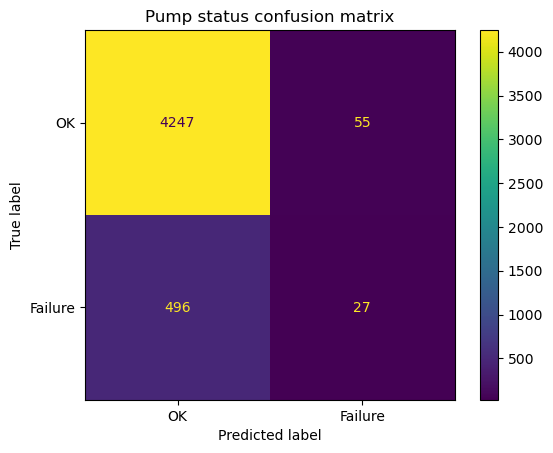

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, model.predict(X_test), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OK', 'Failure'])
s
disp.plot()
plt.title('Pump status confusion matrix')
plt.show()

From confusion matrix we can also see, that there are still lot of cases classified as false positives. Which is unwanted behaviour in this case.

Because of limited time I am required to not continue in testing different approaches, but there are the steps which I would preform:
- dataset balancing (something like oversampling with minority target rows)
- diving deeper into the missing values and their meaning
- more feature engeneering in terms of time series analysis (something like time series decomposition)